In [ ]:
import os
import random

import cv2
from IPython.display import clear_output, HTML
import matplotlib.pyplot as plt
from base64 import b64encode

import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras import models
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras import Input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Activation
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tqdm import tqdm
from sklearn.metrics import classification_report

In [2]:
def show_video(path: str):

    # Cargar el video
    cap = cv2.VideoCapture(path)

    # Verificar si el video se cargó correctamente
    if not cap.isOpened():
        print("Error al cargar el video.")
        cap.release()
        exit()

    # Leer y mostrar cuadro por cuadro
    while True:
        ret, frame = cap.read()  # Leer un cuadro
        if not ret:  # Si no hay más cuadros, salir del bucle
            print("Fin del video.")
            break

        # Convertir el cuadro a RGB (OpenCV usa BGR por defecto)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Mostrar el cuadro en el notebook
        plt.imshow(frame_rgb)
        plt.axis('off')  # Ocultar ejes
        clear_output(wait=True)  # Limpiar la salida anterior
        plt.show()

        # Detener la reproducción después de cierto tiempo
        cv2.waitKey(1)  # Ajusta la velocidad de reproducción

    cap.release()

def show_video_colab(video_path):
    with open(video_path, 'rb') as f:
        video_data = f.read()
    video_url = f"data:video/mp4;base64,{b64encode(video_data).decode()}"

    return HTML(f"""
        <video width="640" height="480" controls>
            <source src="{video_url}" type="video/mp4">
        </video>
    """)

def convert_video_to_mp4(input_path, output_path):
    os.system(f"ffmpeg -i {input_path} -c:v libx264 -c:a aac -strict experimental {output_path}")


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
input_video = "/content/drive/MyDrive/data/nonviolence/NV_412.mp4"
output_video = "/content/converted_video.mp4"

# Convertir el vídeo
convert_video_to_mp4(input_video, output_video)

non violence

In [ ]:
show_video_colab(output_video)

violence

In [ ]:
# show_video("/content/drive/MyDrive/data/Violence/V_29.mp4")
input_video = "/content/drive/MyDrive/data/Violence/V_29.mp4"
output_video = "/content/converted_video_violence.mp4"

# Convertir el vídeo
convert_video_to_mp4(input_video, output_video)
show_video_colab(output_video)

In [4]:
# Function to extract frames at a rate of 3 frames per second
def extract_frames(video_path, output_folder, target_fps=3):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error opening video file: {video_path}")
        return

    original_fps = cap.get(cv2.CAP_PROP_FPS)
    frame_interval = int(original_fps / target_fps)
    frame_count, saved_frame_count = 0, 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % frame_interval == 0:
            frame_filename = f"{os.path.splitext(os.path.basename(video_path))[0]}_frame{saved_frame_count}.jpg"
            cv2.imwrite(os.path.join(output_folder, frame_filename), frame)
            saved_frame_count += 1
        frame_count += 1
    cap.release()

In [5]:
# Function to process videos, splitting 10% for validation if needed
def process_videos(video_paths, train_output, val_output, split_for_val=True):
    for folder in video_paths:
        video_files = [f for f in os.listdir(folder) if f.lower().endswith(('.mp4', '.avi', '.mov', '.mkv'))]

        if split_for_val:
            random.shuffle(video_files)
            val_count = int(len(video_files) * 0.1)  # Take 10% for validation
            val_videos, train_videos = video_files[:val_count], video_files[val_count:]
        else:
            val_videos, train_videos = [], video_files  # All to training if no split

        # Extract frames from validation videos
        for video_file in tqdm(val_videos, desc=f"Extracting validation frames from {folder}"):
            extract_frames(os.path.join(folder, video_file), val_output)

        # Extract frames from training videos
        for video_file in tqdm(train_videos, desc=f"Extracting training frames from {folder}"):
            extract_frames(os.path.join(folder, video_file), train_output)

In [3]:
root_data_extracted_path = "/content/drive/MyDrive/data/extracted_frames"

train_path = f"{root_data_extracted_path}/train"
test_path = f"{root_data_extracted_path}/test"

#Normalize images
def normalize(image, label):
    return tf.cast(image, tf.float32) / 255.0, label

In [4]:
print(train_path)

/content/drive/MyDrive/data/extracted_frames/train


In [ ]:
# Process violence and nonviolence folders with a 10% split for validation
# process_videos(
#     ["data/Violence"],
#     f"{train_path}/violence",
#     f"{test_path}/violence"
# )

process_videos(
    ["data/nonviolence"],
    f"{train_path}/nonviolence",
    f"{test_path}/nonviolence"
)


print("Frame extraction completed.")

Extracting validation frames from data/nonviolence:   0%|          | 0/100 [00:00<?, ?it/s]

Extracting validation frames from data/nonviolence:  72%|███████▏  | 72/100 [02:16<00:56,  2.00s/it][h264 @ 0x656ce80] mb_type 104 in P slice too large at 98 31
[h264 @ 0x656ce80] error while decoding MB 98 31
Extracting validation frames from data/nonviolence: 100%|██████████| 100/100 [03:17<00:00,  1.97s/it]
Extracting training frames from data/nonviolence: 100%|██████████| 900/900 [37:26<00:00,  2.50s/it] 

Frame extraction completed.


In [ ]:
# Dictionary to store file counts
file_counts = {}

# Walk through each subdirectory and count files
for root, dirs, files in os.walk(root_data_extracted_path):
    # Only count files, skip directories
    file_counts[root] = len(files)

# Print the file counts in each folder
for folder, count in file_counts.items():
    print(f"{folder}: {count} files")

/content/drive/MyDrive/data/extracted_frames: 0 files
/content/drive/MyDrive/data/extracted_frames/test: 0 files
/content/drive/MyDrive/data/extracted_frames/test/nonviolence: 1620 files
/content/drive/MyDrive/data/extracted_frames/test/violence: 1564 files
/content/drive/MyDrive/data/extracted_frames/train: 0 files
/content/drive/MyDrive/data/extracted_frames/train/nonviolence: 15166 files
/content/drive/MyDrive/data/extracted_frames/train/violence: 15763 files
/content/drive/MyDrive/data/extracted_frames/train/violence/non_violence: 0 files


In [5]:
import tensorflow as tf

resolver = tf.distribute.cluster_resolver.TPUClusterResolver()  # Detectar TPU
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)
print("All devices:", tf.config.list_logical_devices())

All devices: [LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:TPU:0', device_type='TPU'), LogicalDevice(name='/device:TPU:1', device_type='TPU'), LogicalDevice(name='/device:TPU:2', device_type='TPU'), LogicalDevice(name='/device:TPU:3', device_type='TPU'), LogicalDevice(name='/device:TPU:4', device_type='TPU'), LogicalDevice(name='/device:TPU:5', device_type='TPU'), LogicalDevice(name='/device:TPU:6', device_type='TPU'), LogicalDevice(name='/device:TPU:7', device_type='TPU'), LogicalDevice(name='/device:TPU_SYSTEM:0', device_type='TPU_SYSTEM')]


In [10]:
# from tensorflow.keras.mixed_precision import set_global_policy

# # Habilitar precisión mixta
# set_global_policy('mixed_float16')
# Configuración de datos
batch_size = 640
img_size = (1024, 1024)


train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_path,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="binary"
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_path,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="binary"
)

# Preserve class_names
class_names = test_dataset.class_names

# Aumentar el rendimiento del dataset
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

Found 30929 files belonging to 2 classes.
Found 3184 files belonging to 2 classes.


In [ ]:
with strategy.scope():
    # Define the MobileNetV3Small model
    input_tensor = Input(shape=(img_size[0], img_size[1], 3))
    base_model = MobileNetV3Small(input_shape=(img_size[0], img_size[1], 3), include_top=False, weights='imagenet')

    # base_model.trainable = True  # Habilitar entrenamiento para capas superiores
    # Congelar las primeras capas del modelo base
    for layer in base_model.layers[:-50]:  # Congelar todas las capas excepto las últimas 30
        layer.trainable = False

    # Ahora, descongelar las últimas 30 capas
    for layer in base_model.layers[-50:]:
        layer.trainable = True

    # Add custom layers on top of MobileNetV3Small
    x = base_model(input_tensor)
    x = GlobalAveragePooling2D()(x)

    x = Dense(1024)(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)  # Add Dropout

    x = Dense(512)(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)  # Add Dropout

    output = Dense(1, activation='sigmoid')(x)

    # Build the model
    model = tf.keras.models.Model(inputs=input_tensor, outputs=output)

    model.summary()

    # Optimizer and compilation
    optimizer = Adam(learning_rate=1e-4)

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 512, 512, 3)]     0         
                                                                 
 MobilenetV3small (Function  (None, 16, 16, 576)       939120    
 al)                                                             
                                                                 
 global_average_pooling2d_5  (None, 576)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_15 (Dense)            (None, 1024)              590848    
                                                                 
 activation_10 (Activation)  (None, 1024)              0         
                                                                 
 dropout_10 (Dropout)        (None, 1024)              0   

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

# Callback para guardar el mejor modelo
checkpoint = ModelCheckpoint(
    filepath='/content/best_model.keras',  # Guardar en un directorio accesible
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# Callback para programador de tasas de aprendizaje
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_callback = LearningRateScheduler(scheduler)

In [ ]:
# Entrenamiento
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=30,
    callbacks=[checkpoint, lr_callback]
)

Epoch 1/30
61/61 [==============================] - ETA: 0s - loss: 0.5910 - accuracy: 0.6813
Epoch 1: val_loss improved from inf to 0.70765, saving model to /content/best_model.keras
61/61 [==============================] - 648s 10s/step - loss: 0.5910 - accuracy: 0.6813 - val_loss: 0.7077 - val_accuracy: 0.5088 - lr: 1.0000e-04
Epoch 2/30
61/61 [==============================] - ETA: 0s - loss: 0.4297 - accuracy: 0.7982
Epoch 2: val_loss did not improve from 0.70765
61/61 [==============================] - 381s 6s/step - loss: 0.4297 - accuracy: 0.7982 - val_loss: 0.7337 - val_accuracy: 0.5088 - lr: 1.0000e-04
Epoch 3/30
61/61 [==============================] - ETA: 0s - loss: 0.3313 - accuracy: 0.8552
Epoch 3: val_loss did not improve from 0.70765
61/61 [==============================] - 377s 6s/step - loss: 0.3313 - accuracy: 0.8552 - val_loss: 0.7912 - val_accuracy: 0.5088 - lr: 1.0000e-04
Epoch 4/30
61/61 [==============================] - ETA: 0s - loss: 0.2815 - accuracy: 0.878

KeyboardInterrupt: 

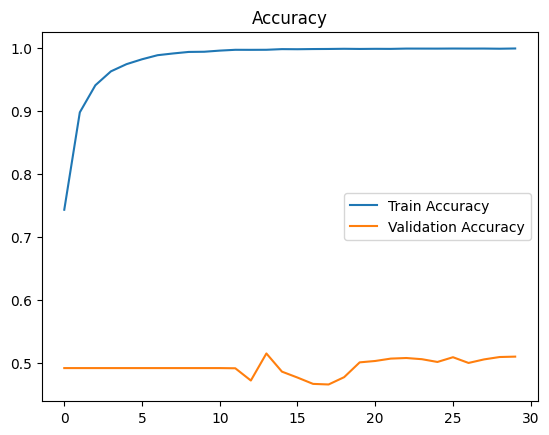

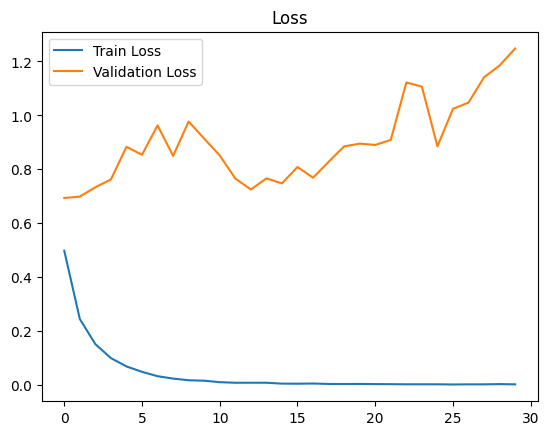

In [ ]:
# Plotear precisión
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

# Plotear pérdida
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [ ]:
# Step 1: Evaluate the model using the validation generator
loss, accuracy = model.evaluate(test_dataset, verbose=1)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

7/7 [==============================] - 10s 404ms/step - loss: 1.2470 - accuracy: 0.5097
Validation Loss: 1.247025966644287
Validation Accuracy: 0.509736180305481


In [ ]:
import numpy as np

# Obtener etiquetas verdaderas
y_true = []
y_pred = []

for images, labels in test_dataset:
    # Etiquetas reales
    y_true.extend(labels.numpy())
    # Predicciones del modelo
    preds = model.predict(images)  # Si es clasificación binaria
    y_pred.extend(np.round(preds).flatten())  # Redondear para obtener 0 o 1

y_true = np.array(y_true)
y_pred = np.array(y_pred)

4/4 [==============================] - 1s 32ms/step


In [ ]:
from sklearn.metrics import classification_report
# # Convertir las predicciones continuas a clases binarias (0 o 1) usando un umbral de 0.5
# y_pred = (y_pred > 0.5).astype(int)
# Generar el informe de clasificación
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

              precision    recall  f1-score   support

 nonviolence       0.51      0.98      0.67      1620
    violence       0.53      0.02      0.04      1564

    accuracy                           0.51      3184
   macro avg       0.52      0.50      0.35      3184
weighted avg       0.52      0.51      0.36      3184



In [6]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

with strategy.scope():
    # Modelo base preentrenado ajustado para 512x512
    base_model = EfficientNetB3(input_shape=(512, 512, 3), include_top=False, weights='imagenet')

    # Congelar las primeras capas
    base_model.trainable = False

    # Construir el modelo
    input_tensor = layers.Input(shape=(512, 512, 3))
    x = base_model(input_tensor)
    x = layers.GlobalAveragePooling2D()(x)

    # Capas densas con Batch Normalization
    x = layers.Dense(1024)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(512)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)

    # Salida
    output = layers.Dense(1, activation='sigmoid')(x)

    # Crear el modelo
    model = models.Model(inputs=input_tensor, outputs=output)

    # Compilar el modelo
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Callbacks
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)
    checkpoint = ModelCheckpoint('best_efficientnet_tpu.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

batch_size = 640
img_size = (512, 512)


train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_path,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="binary"
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_path,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="binary"
)

# Preserve class_names
class_names = test_dataset.class_names

# Aumentar el rendimiento del dataset
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

43941136/43941136 [==============================] - 0s 0us/step
Found 30929 files belonging to 2 classes.
Found 3184 files belonging to 2 classes.


In [8]:
# Entrenamiento
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=30,
    callbacks=[checkpoint, reduce_lr]
)

Epoch 1/30
49/49 [==============================] - ETA: 0s - loss: 0.8156 - accuracy: 0.5303
Epoch 1: val_loss improved from inf to 0.71405, saving model to best_efficientnet_tpu.keras
49/49 [==============================] - 1036s 11s/step - loss: 0.8156 - accuracy: 0.5303 - val_loss: 0.7140 - val_accuracy: 0.4912 - lr: 1.0000e-04
Epoch 2/30
49/49 [==============================] - ETA: 0s - loss: 0.7722 - accuracy: 0.5478
Epoch 2: val_loss did not improve from 0.71405
49/49 [==============================] - 405s 8s/step - loss: 0.7722 - accuracy: 0.5478 - val_loss: 0.7289 - val_accuracy: 0.4912 - lr: 1.0000e-04
Epoch 3/30
49/49 [==============================] - ETA: 0s - loss: 0.7579 - accuracy: 0.5499
Epoch 3: val_loss did not improve from 0.71405
49/49 [==============================] - 410s 8s/step - loss: 0.7579 - accuracy: 0.5499 - val_loss: 0.7279 - val_accuracy: 0.4912 - lr: 1.0000e-04
Epoch 4/30
49/49 [==============================] - ETA: 0s - loss: 0.7469 - accuracy: 0.

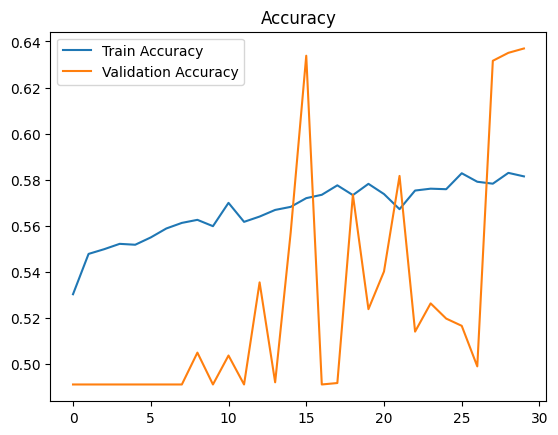

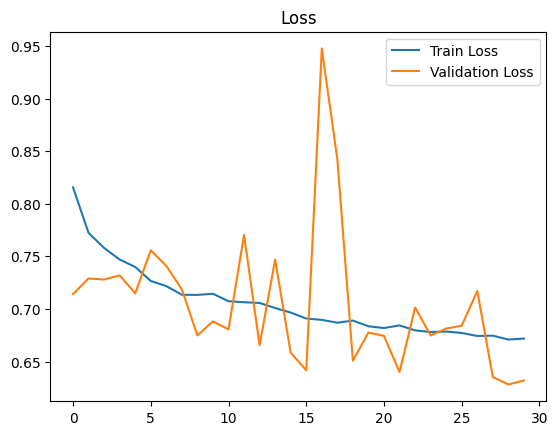

In [9]:
# Plotear precisión
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

# Plotear pérdida
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()


In [10]:
# Step 1: Evaluate the model using the validation generator
loss, accuracy = model.evaluate(test_dataset, verbose=1)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

5/5 [==============================] - 43s 5s/step - loss: 0.6323 - accuracy: 0.6344
Validation Loss: 0.6323065757751465
Validation Accuracy: 0.6344221234321594


In [11]:
import numpy as np

# Obtener etiquetas verdaderas
y_true = []
y_pred = []

for images, labels in test_dataset:
    # Etiquetas reales
    y_true.extend(labels.numpy())
    # Predicciones del modelo
    preds = model.predict(images)  # Si es clasificación binaria
    y_pred.extend(np.round(preds).flatten())  # Redondear para obtener 0 o 1

y_true = np.array(y_true)
y_pred = np.array(y_pred)

20/20 [==============================] - 53s 1s/step


In [12]:
from sklearn.metrics import classification_report
# # Convertir las predicciones continuas a clases binarias (0 o 1) usando un umbral de 0.5
# y_pred = (y_pred > 0.5).astype(int)
# Generar el informe de clasificación
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

              precision    recall  f1-score   support

 nonviolence       0.69      0.49      0.57      1620
    violence       0.59      0.77      0.67      1564

    accuracy                           0.63      3184
   macro avg       0.64      0.63      0.62      3184
weighted avg       0.64      0.63      0.62      3184



### mejor modelo

In [ ]:
import tensorflow as tf

resolver = tf.distribute.cluster_resolver.TPUClusterResolver()  # Detectar TPU
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)
print("All devices:", tf.config.list_logical_devices())

In [7]:
batch_size = 640
img_size = (512, 512)


train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_path,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="binary"
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_path,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="binary"
)

# Preserve class_names
class_names = test_dataset.class_names

# Aumentar el rendimiento del dataset
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

Found 30929 files belonging to 2 classes.
Found 3184 files belonging to 2 classes.


In [8]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf

with strategy.scope():
    input_tensor = layers.Input(shape=(512, 512, 3))

    # Modelo base ResNet50
    base_model = ResNet50(input_shape=(512, 512, 3), include_top=False, weights='imagenet')

    # Descongelar las últimas capas
    base_model.trainable = True
    for layer in base_model.layers[:-100]:  # Congelar todas menos las últimas 100 capas
        layer.trainable = False

    # Construcción de las capas superiores
    x = base_model(input_tensor)
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(1024)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(512)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)

    # Salida
    output = layers.Dense(1, activation='sigmoid')(x)

    # Crear el modelo
    model_resnet = models.Model(inputs=input_tensor, outputs=output)

    # Compilación del modelo
    optimizer = Adam(learning_rate=1e-4)
    model_resnet.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)
checkpoint = ModelCheckpoint(filepath='resnet50_model.h5', save_best_only=True, monitor='val_loss', mode='min')


94765736/94765736 [==============================] - 0s 0us/step


In [9]:
# Entrenamiento
history = model_resnet.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=30,
    callbacks=[reduce_lr, checkpoint]
)

Epoch 1/30
49/49 [==============================] - ETA: 0s - loss: 0.3796 - accuracy: 0.8181

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 847s 12s/step - loss: 0.3796 - accuracy: 0.8181 - val_loss: 1.0865 - val_accuracy: 0.5088 - lr: 1.0000e-04
Epoch 2/30
49/49 [==============================] - 419s 8s/step - loss: 0.1379 - accuracy: 0.9459 - val_loss: 0.8689 - val_accuracy: 0.5223 - lr: 1.0000e-04
Epoch 3/30
49/49 [==============================] - 406s 8s/step - loss: 0.0782 - accuracy: 0.9707 - val_loss: 1.0481 - val_accuracy: 0.5716 - lr: 1.0000e-04
Epoch 4/30
49/49 [==============================] - 403s 8s/step - loss: 0.0376 - accuracy: 0.9876 - val_loss: 2.3527 - val_accuracy: 0.5361 - lr: 1.0000e-04
Epoch 5/30
49/49 [==============================] - 406s 8s/step - loss: 0.0240 - accuracy: 0.9921 - val_loss: 1.4209 - val_accuracy: 0.5948 - lr: 1.0000e-04
Epoch 6/30
49/49 [==============================] - 425s 8s/step - loss: 0.0263 - accuracy: 0.9910 - val_loss: 1.3295 - val_accuracy: 0.6190 - lr: 1.0000e-04
Epoch 7/30
49/49 [==============================] - 411s 8s/st

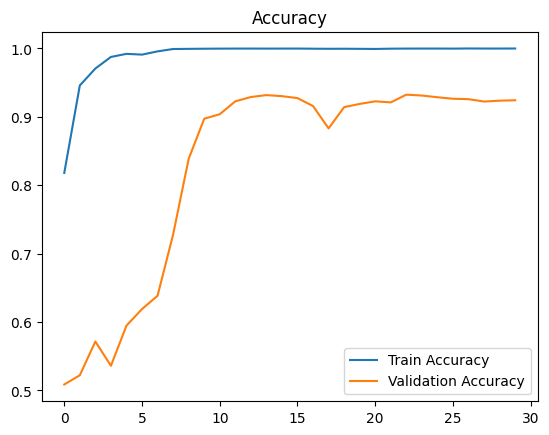

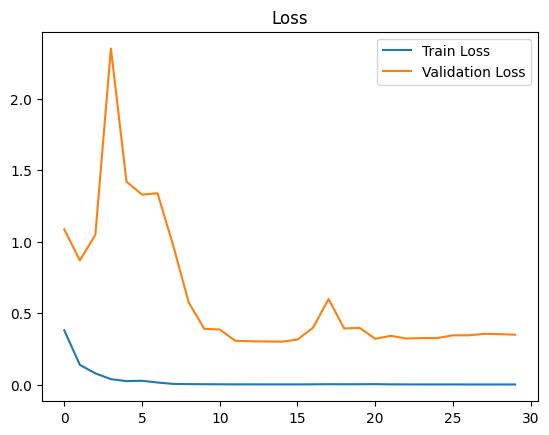

In [10]:
# Plotear precisión
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

# Plotear pérdida
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [14]:
# Step 1: Evaluate the model using the validation generator
loss, accuracy = model_resnet.evaluate(test_dataset, verbose=1)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

5/5 [==============================] - 40s 4s/step - loss: 0.3478 - accuracy: 0.9256
Validation Loss: 0.3477964997291565
Validation Accuracy: 0.9255653023719788


In [15]:
import numpy as np

# Obtener etiquetas verdaderas
y_true = []
y_pred = []

for images, labels in test_dataset:
    # Etiquetas reales
    y_true.extend(labels.numpy())
    # Predicciones del modelo
    preds = model_resnet.predict(images)  # Si es clasificación binaria
    y_pred.extend(np.round(preds).flatten())  # Redondear para obtener 0 o 1

y_true = np.array(y_true)
y_pred = np.array(y_pred)

20/20 [==============================] - 36s 869ms/step


In [16]:
from sklearn.metrics import classification_report
# Generar el informe de clasificación
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

              precision    recall  f1-score   support

 nonviolence       0.95      0.90      0.92      1620
    violence       0.90      0.96      0.93      1564

    accuracy                           0.93      3184
   macro avg       0.93      0.93      0.93      3184
weighted avg       0.93      0.93      0.93      3184



In [ ]:
# Generar y guardar el esquema del modelo
plot_model(model_resnet, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


In [ ]:
model_resnet.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 518, 518,  │          0 │ input_layer_7[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 256, 256,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 256, 256,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 256, 256,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 258, 258,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 128, 128,  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 128, 128,  │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 128, 128,  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 128, 128,  │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 128, 128,  │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 128, 128,  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 128, 128,  │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 128, 128,  │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 128, 128,  │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 128, 128,  │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 128, 128,  │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 22,151,936 (84.50 MB)

 Non-trainable params: 1,435,776 (5.48 MB)